In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import scipy
import scipy.stats as st
from pylab import cm
from matplotlib import colors as mcol
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib.gridspec import GridSpec

from netCDF4 import Dataset as NetCDFFile

In [2]:
mk_df = pd.read_csv('results-mk-lc.txt', sep=',', index_col='site')
att_df = pd.read_csv('attributes_with_NWM_LSTM_PP.csv', sep=',', index_col='gauge_id')
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in att_df.index.values:
    basin_id_str.append(str(a).zfill(8))
att_df['basin_id_str'] = basin_id_str

In [3]:
# Get the hydrologic units for each basin.
with open('usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in att_df.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
att_df['basin_hydro_unit'] = basin_hydro_unit

In [4]:
df = mk_df.join(att_df)

In [5]:
df = df.dropna()

In [6]:
df.columns.values

array(['potential_evaporation', 'skin_temperature',
       'soil_temperature_level_1',
       'evaporation_from_vegetation_transpiration', 'lat', 'lon', 'P',
       'Q', 'P-Q', 'Q/P', '(P-Q)/P', 'tree_canopy_cover', 'impervious',
       'q_mean', 'runoff_ratio', 'slope_fdc', 'baseflow_index',
       'stream_elas', 'q5', 'q95', 'high_q_freq', 'high_q_dur',
       'low_q_freq', 'low_q_dur', 'hfd_mean', 'geol_1st_class',
       'glim_1st_class_frac', 'carbonate_rocks_frac', 'geol_porostiy',
       'geol_permeability', 'p_mean', 'pet_mean', 'p_seasonality',
       'frac_snow', 'aridity', 'high_prec_freq', 'high_prec_dur',
       'low_prec_freq', 'low_prec_dur', 'low_prec_timing', 'gauge_lat',
       'gauge_lon', 'elev_mean', 'area_gages2', 'area_geospa_fabric',
       'soil_depth_pelletier', 'soil_depth_statsgo', 'max_water_content',
       'sand_frac', 'silt_frac', 'clay_frac', 'other_frac', 'frac_forest',
       'lai_max', 'gvf_max', 'dom_land_cover_frac', 'dom_land_cover',
       'basin

In [7]:
# Function to sort lists based on another list
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z

# Function to print statistics
def print_stats(d):
    print("mean = {:.2f},  median = {:.2f}, stdev = {:.2f}, min = {:.2f}, max = {:.2f}".format(
        np.nanmean(np.array(d)),
        np.nanmedian(np.array(d)),
        np.nanstd(np.array(d)),
        np.nanmin(np.array(d)),
        np.nanmax(np.array(d))
        )
    )

# Random Forest Regression in a K-fold loop
def cross_val_rf(X, y, feature_list, kf, ynormal=False, n_estimators=10, random_state=42, criterion='squared_error', min_samples_leaf=1, min_samples_split=2, max_depth=None, min_weight_fraction_leaf=0, feature_list_short=[]):
    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_hat_indx_list = []
    
    # Set the style of the seaborn plot
    sns.set(style="whitegrid")

    fig = plt.figure(figsize=(7, 4))  # Adjust the figure size as needed
    grid = GridSpec(1, 5, fig, wspace=0.4)  # Increase the wspace value to provide more space

    # Scatter plot
    ax1 = fig.add_subplot(grid[0, :3])  # Assign more space to the scatter plot
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                  criterion=criterion, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, max_depth=max_depth,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf)
        rf.fit(X_train, y_train)
        y_hat = rf.predict(X_test)

        # Get numerical feature importances
        importances = list(rf.feature_importances_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
        sns.scatterplot(x=y_test, y=y_hat, color="blue", alpha=0.6, ax=ax1)  # Use grey color

        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / kf.get_n_splits()

    # Set plot labels and titles
    plt.xlabel("True Target Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.title("Cross-Validation Results", fontsize=14)

    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x = np.linspace(np.min(y), np.max(y), num=100)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    plt.xlim([omin, omax])
    plt.ylim([omin, omax])
    plt.plot(x, x * slope + intercept, color="blue", lw=2)
    plt.grid()

    ax1.set_xlabel("True Target Values")
    ax1.set_ylabel("Predicted Values")
    ax1.grid(True)

    # Feature importance plot
    ax2 = fig.add_subplot(grid[0, 4])  # Assign one column space to the feature importance plot
    feature_importances.sort_values('total_importance', ascending=False).iloc[0:5].plot.bar(ax=ax2, color='blue', legend=False)
    ax2.set_ylabel('Feature Importance')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances


In [8]:
# Set the training and targets.
def set_X_y(df, regressor_attributes, target, xnormal=False, ynormal=False, xlog=False, ylog=False):
    X = np.array(df.loc[:, regressor_attributes])

    y = np.array(df[target])

    X_krig = np.array(df.loc[:, ['gauge_lat', 'gauge_lon']])

    if ynormal:
        y_mean = np.nanmean(y)
        y_std = np.nanstd(y)
        y = (y - y_mean) / y_std

    if xnormal:
        for i, r in enumerate(regressor_attributes):
            iX = np.array(df.loc[:, r])
            X_mean = np.nanmean(iX)
            X_std = np.nanstd(iX)
            X[:, i] = (iX - X_mean) / X_std

    if xlog:
        for i, r in enumerate(regressor_attributes):
            for iX in range(X.shape[0]):
                if np.abs(np.log(np.array(df.iloc[iX, i]))) > 0:
                    X[iX, i] = np.log(np.array(df.iloc[iX, i]))

    if ylog:
        for iy in range(y.shape[0]):
            if np.abs(np.log(y[iy])) > 0:
                y[iy] = np.log(y[iy])

    return X, y

In [9]:
for i in range(df.shape[0]):
    df.basin_hydro_unit.iloc[i] = int(df.basin_hydro_unit.iloc[i])

/tmp/ipykernel_7496/86091597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.basin_hydro_unit.iloc[i] = int(df.basin_hydro_unit.iloc[i])


Overall rmse for the out-of-sample predictions: 0.63
Overall r^2 for the out-of-sample predictions: 0.61
RMSE Value stats for cross validation
mean = 0.62,  median = 0.61, stdev = 0.07, min = 0.52, max = 0.76
R-squared Value stats for cross validation
mean = 0.62,  median = 0.64, stdev = 0.09, min = 0.48, max = 0.75


/tmp/ipykernel_7496/861144985.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


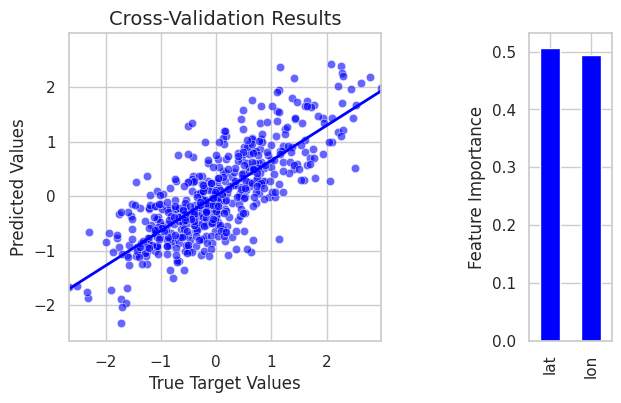

In [10]:
# Make a dictionary for all the X, y values
regressor_attributes = ['lat', 'lon']
feature_list_short = []
target='Q/P'
ynormal = True
X_target, y_target = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=10, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X_target,y_target,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='squared_error', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0)

In [11]:
df['forest'] = df['tree_canopy_cover']
df['imperv'] = df['impervious']

Overall rmse for the out-of-sample predictions: 1.09
Overall r^2 for the out-of-sample predictions: 0.00
RMSE Value stats for cross validation
mean = 1.08,  median = 1.08, stdev = 0.13, min = 0.86, max = 1.37
R-squared Value stats for cross validation
mean = 0.05,  median = 0.02, stdev = 0.06, min = 0.00, max = 0.26


/tmp/ipykernel_7496/861144985.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


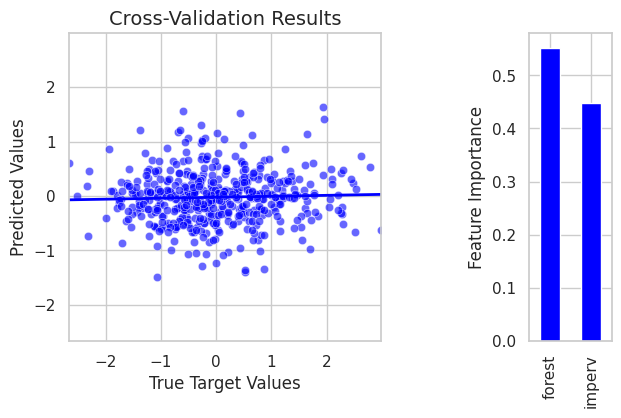

In [12]:
# Make a dictionary for all the X, y values
regressor_attributes = ['forest', 'imperv']
feature_list_short = []
target='Q/P'
ynormal = True
X_target, y_target = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat_target, rmse, r2, feature_importance = cross_val_rf(X_target,y_target,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='squared_error', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0)

In [13]:
df['evap'] = df['potential_evaporation']
df['skinT'] = df['skin_temperature']
df['soilT'] = df['soil_temperature_level_1']
df['trans'] = df['evaporation_from_vegetation_transpiration']

Overall rmse for the out-of-sample predictions: 0.77
Overall r^2 for the out-of-sample predictions: 0.42
RMSE Value stats for cross validation
mean = 0.76,  median = 0.73, stdev = 0.10, min = 0.60, max = 1.00
R-squared Value stats for cross validation
mean = 0.43,  median = 0.43, stdev = 0.15, min = 0.15, max = 0.64


/tmp/ipykernel_7496/861144985.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


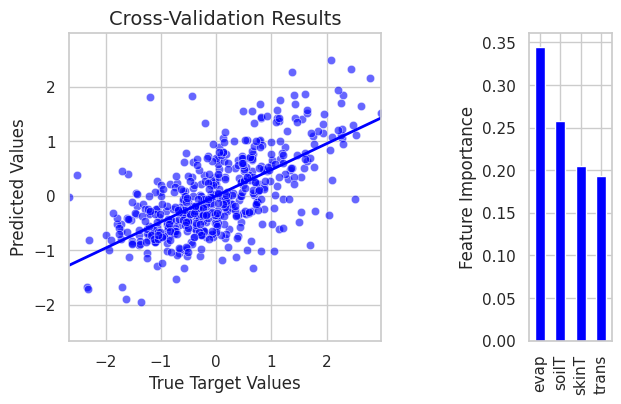

In [14]:
regressor_attributes = ['evap','skinT','soilT','trans']
feature_list_short = []
target='Q/P'
ynormal = True
X_target, y_target = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X_target,y_target,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='squared_error', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0)